# Spark - Exploratory Data Analysis

In this courselet, we will explore the use of Spark as a Data Science tool when working with Big Data. By the end of this courselet, you would be able to:

- Perform a descriptive analysis
- Compare the performance of Spark under different data formats (csv vs. parquet)
- Identify the advantages of using Spark in a cluster, by relying on different optimization strategies.

## What is Spark?

[Apache Spark](https://spark.apache.org/) is an open-source engine used for the processing and analysis of large-scale data. Today, Spark is one of the most popular frameworks for the developement of data engineering, data science and machine learning tasks.

## Advantages of Spark

- Multi-language: It can be implemented through multiple-languages (Python, R, Java, Scala), making it flexible for diverse users
- Speed: Spark leverages on RAM to perform it's computational tasks, which translates into faster data processing
- Parallelism and fault tolerance: Spark is designed to be used in the context of a multi-node cluster. Therefore, its design aims for a parallel data processing across nodes, as well as fault tolerance in the case that a node presents a failure
- Wide community of users: Given it's popularity, there is a huge open-source community, which allows Spark to be constantly developed and improved

## Disadvantages of Spark

- Memory consumption: Given that Spark uses RAM to optimize speed in processing, this can also lead to several instances of *OutOfMemory* error if not managed properly 
- Manual fine-tuning and optimization: To optimize the overall performance of Spark, the user must manually [tune the settings](https://www.databricks.com/glossary/spark-tuning) of the cluster in terms of hardware. This process is not straightforward and a inadequate setting up might result in a non-optimal perfomance
- Inneficient management of small files: For cases of small datafiles, Spark is not an optimal framework, given the high transaction cost of distributing and collecting data across nodes. For the case of small datafiles, using Pandas or a more conventional approach is more efficient

## Importing libraries and starting our Spark session.

To start working, we are first going to import our main library and initialize both our [SparkSession](https://spark.apache.org/docs/latest/sql-getting-started.html#starting-point-sparksession) and our [SparkContext](https://spark.apache.org/docs/3.2.0/api/java/org/apache/spark/SparkContext.html).

In [1]:
import pyspark
from pyspark.sql import SparkSession
# Starting our Spark Session
spark = SparkSession.builder \
    .appName("EDA Spark") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

# Starting our Spark Context
sc = spark.sparkContext

## RDD

The [Resilient Distributed Dataset (RDD)](https://spark.apache.org/docs/latest/rdd-programming-guide.html) is the main data structure in Spark. It consist of a collection of object distributed across the nodes of the cluster. This allows for the processes to be parallelized across the nodes, and to guarantee fault tolerance. RDD's posses two fundamental types of operations: **transformations**,  which are operations that convert RDD's into new RDD's, and **actions**, which return non-RDD values/objects.

A fundamental piece of Spark's design is the concept of [lazy evaluation](https://towardsdatascience.com/3-reasons-why-sparks-lazy-evaluation-is-useful-ed06e27360c4). This concept refers to an execution plan in which Spark does not perform a computational task until explicitly intructred to do so. When we perform a transformation and create a new RDD, Spark does not perform any computation at that point. Instead, what it creates is an execution plan. It is not until we perform an action, when Spark actually executes the task and returns a new object. In this way, the user can perform as many transformations as desired, but non of them will be executed until an action is performed, achieving a more efficient use of the resources.

Let's now work with an example RDD.

In [2]:
# We start by creating a list of values
lst = [i for i in range(1000000)]
# Executing the function "parallelize", converts our list into an RDD
rdd = sc.parallelize(lst)
rdd # As we will see, the representation of the RDD is not a list anymore

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:289

In [3]:
# Performing a transformation. 
squared_rdd = rdd.map(lambda x: x**2) # Transforming our RDD into a new one with the values squared
squared_rdd # As we stated previously, the previous transformation created a new RDD, but no computation has been performed

PythonRDD[1] at RDD at PythonRDD.scala:53

In [4]:
squared_rdd = squared_rdd.collect() # Performing and action to collect our RDD into a list again
squared_rdd[:16] # Now we have a list of squared values. We only show the first 16 values

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225]

In [5]:
# Another transformation
filtered_rdd = rdd.filter(lambda x: x % 2 == 0) # Filtering our RDD into a new one with even numbers. This is a transformation
filtered_rdd.count() # Returning the count of even numbers. This is our action

500000

The previous example showed a series of tasks over a list which was transformed into an RDD. However, the creation of RDD's is not limited to lists. Multiple data sources can be transformed into RDD's to take advantage of the distribution principle. In the next cells of code, we are going to perform a very common task, which is counting the frequencies of words in a given text. For that, we are going to do the following:

1. Install the nltk library to make use of their stopwords list
2. Load our shakespeare.txt file, which is a compilation with all the works from William Shakespeare
3. Perform a series of transformations, before calling an action and returning a list of tuples with the 10 most frequent words in Shakespeare works, and their frequency

In [6]:
!pip install nltk > NULL

In [7]:
# Downloading the stopwords collection
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1006)>


False

In [8]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
shakespeare = spark.read.text("data/shakespeare.txt") 
shakespeare # By using the read.text function, our txt file is read as a DataFrame. We will explore further on DataFrames after this example.

DataFrame[value: string]

In [10]:
top_words = (
    shakespeare
    .rdd.flatMap(lambda line: line[0].split(" ")) # First, we convert the DataFrame into an RDD, we "flatten" the elements of the RDD and split them by space. Basically, we make a list of all the words
    .filter(lambda word: word.lower() not in stop_words and word != "") # Now we filter each word lowered, removing stop words and empty strings 
    .map(lambda word: (word, 1)) # For each word, we create a tuple with the word (which represents the key) and a value of 1 as a count. This tuple represents a Key-Value pair (K,V)
    .reduceByKey(lambda x, y: x + y) #For each Key, we perform the specified function on it's values. In this case, it is a sum of the Values with the same Key (x+y)
    .sortBy(lambda x: x[1], ascending=False) # We sort the tuples by the count, in descending order
    .take(10) # It is here where we perform an action and return the first 10 tuples
)

top_words

[('thou', 4247),
 ('thy', 3630),
 ('shall', 3016),
 ('good', 2046),
 ('would', 1974),
 ('Enter', 1926),
 ('thee', 1780),
 ("I'll", 1737),
 ('hath', 1614),
 ('like', 1453)]

## DataFrames

Another essential data structure in Spark, particularly for data analysis, are DataFrames, or Distributed DataFrames. This type of DataFrame is built on top of RDD's, but with the advantage of having a better defined structure, providing a schema and facilitating the interaction with the data and query execution. It also follows Spark's principle of distributed data processing across the different nodes.

For this courselet, we are exploring the taxi trips reported to the City of Chicago in 2020. This data is publicly available through the [Chicago Data Portal](https://data.cityofchicago.org/en/Transportation/Taxi-Trips-2020/r2u4-wwk3/about_data). 

We will proceed to load our data.

In [11]:
df = spark.read.csv("data/chicago-taxi-2020.csv",header=True, inferSchema=True)

As the our first actions, we can print the schema of the data, and count the number of rows.

In [12]:
df.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

In [13]:
df.count()

3889032

In [14]:
# We can take a subset of the data
df[['Trip ID', 'Trip Total']]

DataFrame[Trip ID: string, Trip Total: double]

As it happens with RDD's, dataframes also follow the principle of lazy evaluation. In this case, when we called for a subsetting of the dataframe, Spark only returned a logical representation of it. If we want to actually display values, we must perform an action. 

In [15]:
df[['Trip ID', 'Trip Total']].show(10) # We are going to show the first 10 rows

+--------------------+----------+
|             Trip ID|Trip Total|
+--------------------+----------+
|16c7456d99031528c...|     12.27|
|472eef1d5c7a5e5ee...|      13.0|
|031a4d882fb3315a4...|      14.8|
|3c416c246829dfb3f...|      9.75|
|3c0a22971ae070ce3...|      6.75|
|451beabd5dd8ffc54...|     12.25|
|60da9b02b3297dc58...|      21.6|
|64bd098989d7ad38a...|      12.0|
|8e2fa4ad2d00c7372...|     25.25|
|9323dfcf3aa6b0e8c...|      7.75|
+--------------------+----------+
only showing top 10 rows



# Descriptive Statistics

To support our operations, we are going to use the collections of functions provided by pyspark.sql. You can consult the full list in the [source documentation.](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.max.html)

In [16]:
import pyspark.sql.functions as F

In [17]:
# Mean of a column
df.select(F.mean("Trip Total"))

DataFrame[avg(Trip Total): double]

As you can observe, our previous line of code has not returned the mean yet. Instead, it returned a DataFrame object. We must perform an action to display the mean. The following line of code extends the previous one with the extension of the *show.()* action.

In [18]:
df.select(F.mean("Trip Total")).show()

+------------------+
|   avg(Trip Total)|
+------------------+
|18.368485537583467|
+------------------+



In [19]:
# Mean of multiple columns
df.select(F.mean("Trip Total"), F.mean("Trip Seconds")).show()

+------------------+-----------------+
|   avg(Trip Total)|avg(Trip Seconds)|
+------------------+-----------------+
|18.368485537583467|874.7527292080763|
+------------------+-----------------+



In [20]:
# Max value of a column
df.select(F.max("Trip Total")).show()

+---------------+
|max(Trip Total)|
+---------------+
|        9955.55|
+---------------+



We can also perform more complex analysis by grouping information and performing multiple tasks in the line of code.

In [21]:
# Calculating the average trip total by community area.
df.groupBy("Pickup Community Area") \
    .agg(F.avg("Trip Total")
    .alias("AVG Trip Total")) \
    .na.drop(subset=["Pickup Community Area"]) \
    .orderBy(F.col("Pickup Community Area")).show()

+---------------------+------------------+
|Pickup Community Area|    AVG Trip Total|
+---------------------+------------------+
|                    1|14.904347051776057|
|                    2| 14.70952342712419|
|                    3|13.594861907566413|
|                    4|13.487912290478846|
|                    5|13.498661423394251|
|                    6|13.551174231054802|
|                    7|13.730048243649625|
|                    8| 12.73943802183018|
|                    9|19.907711711711713|
|                   10|19.228908232118755|
|                   11|15.682493122165216|
|                   12| 20.35279255319149|
|                   13|14.851200775475585|
|                   14|15.245882238505935|
|                   15|14.950861089792784|
|                   16|14.187686900245485|
|                   17|19.169364141765108|
|                   18|19.993140495867767|
|                   19|16.654314882756417|
|                   20| 18.53338563956253|
+----------

In [22]:
# Evaluatin the missingness rate per column
missingness = df.agg(*[(1 - (F.count(F.col(c)) / F.count('*')))
         .alias(c + '_missing_rate') for c in df.columns])
missingness.show() 

+--------------------+--------------------+---------------------------------+-------------------------------+-------------------------+-----------------------+--------------------------------+---------------------------------+----------------------------------+-----------------------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+-------------------------+--------------------+-------------------------------------+--------------------------------------+-------------------------------------+--------------------------------------+---------------------------------------+---------------------------------------+
|Trip ID_missing_rate|Taxi ID_missing_rate|Trip Start Timestamp_missing_rate|Trip End Timestamp_missing_rate|Trip Seconds_missing_rate|Trip Miles_missing_rate|Pickup Census Tract_missing_rate|Dropoff Census Tract_missing_rate|Pickup Community Area_missing_rate|Dropoff Community Area_missing_rate|   Fare_missing_

Results don't look good right? They are not readable at all. Maybe we should perform a different type of action method. 

The *.toPandas()* method allows us to convert an RDD into a Pandas dataframe. It is especially recommended if we expect the output of our query to be small. Let's use that to show our missingness rates:

In [23]:
missingness.toPandas()

,Trip ID_missing_rate,Taxi ID_missing_rate,Trip Start Timestamp_missing_rate,Trip End Timestamp_missing_rate,Trip Seconds_missing_rate,Trip Miles_missing_rate,Pickup Census Tract_missing_rate,Dropoff Census Tract_missing_rate,Pickup Community Area_missing_rate,Dropoff Community Area_missing_rate,...,Extras_missing_rate,Trip Total_missing_rate,Payment Type_missing_rate,Company_missing_rate,Pickup Centroid Latitude_missing_rate,Pickup Centroid Longitude_missing_rate,Pickup Centroid Location_missing_rate,Dropoff Centroid Latitude_missing_rate,Dropoff Centroid Longitude_missing_rate,Dropoff Centroid Location_missing_rate
0,0.0,0.0,0.0,0.000148,0.000398,0.000008,0.541555,0.544762,0.071719,0.094838,...,0.000085,0.000085,0.0,0.0,0.071538,0.071538,0.071538,0.093113,0.093113,0.093113


Much better!

# Spark SQL

One of the main features in Spark is the incorporation of an SQL module which allows us to analyze strcutured data through the use of SQL Queries. Let's take a look at some examples.

In [24]:
df.createOrReplaceTempView("trips") # We create this temporary view so Spark recognizes our DataFrame as a table when writing queries.

In [25]:
# Select the Taxi ID that charged the most expensive trip
spark.sql("""
    SELECT `Taxi ID`
    FROM trips
    WHERE `Trip Total` = (SELECT MAX(`Trip Total`) FROM trips)""").show()

+--------------------+
|             Taxi ID|
+--------------------+
|687e3ef9daf087b79...|
+--------------------+



In [26]:
# Select the 5 companies with the highest avg fares
spark.sql("""
    SELECT company, AVG(Fare) as avg_fare
    FROM trips
    GROUP BY Company
    ORDER BY avg_fare DESC
    LIMIT 5
""").show()

+--------------------+------------------+
|             company|          avg_fare|
+--------------------+------------------+
|    Metro Jet Taxi A| 294.1724863192956|
|     Chicago Taxicab| 59.78360585544373|
|Suburban Dispatch...|38.412117919486995|
|4053 - 40193 Adwa...| 27.02038626609442|
|4623 - 27290 Jay Kim|26.991394148020653|
+--------------------+------------------+



## Visualizing Data

Spark does not count with a dedicated library or API for data visualization. However, we can generate non-RDD objects and plot them through the use of conventional python libraries like Matpolib or Seaborn. 

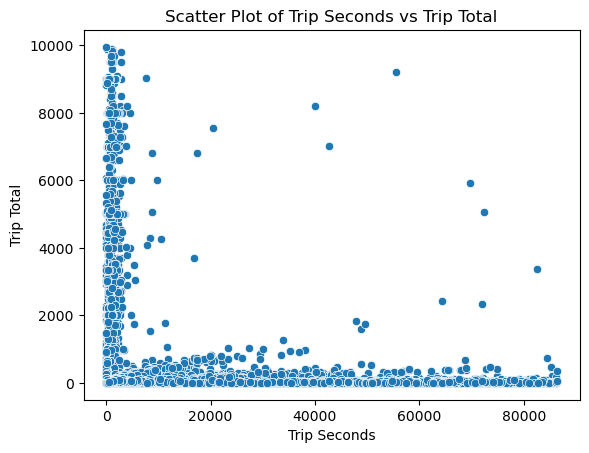

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# We create a list of for each column to visualize.
trip_seconds = df.select('Trip Seconds').rdd.flatMap(lambda x: x).collect() 
trip_total = df.select('Trip Total').rdd.flatMap(lambda x: x).collect()

sns.scatterplot(x=trip_seconds, y=trip_total)
plt.title('Scatter Plot of Trip Seconds vs Trip Total')
plt.xlabel('Trip Seconds')
plt.ylabel('Trip Total')
plt.show()

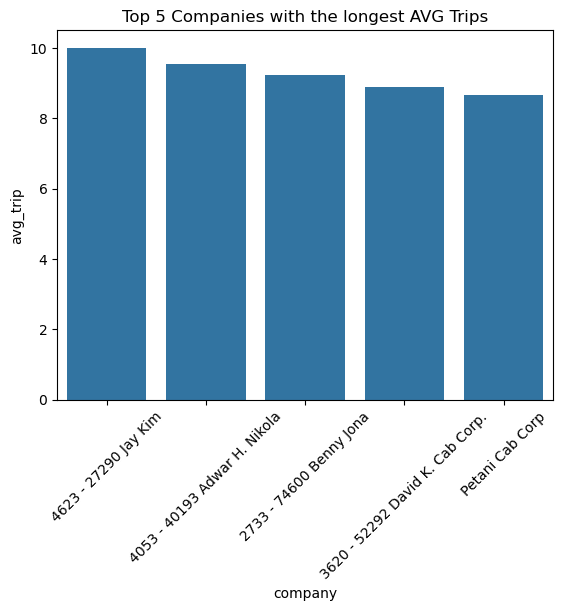

In [28]:
pandas_df = spark.sql("""
    SELECT company, AVG(`Trip Miles`) as avg_trip
    FROM trips
    GROUP BY Company
    ORDER BY avg_trip DESC
    LIMIT 5
""").toPandas() # Another approach is to query our table, and create a simple PandasDF from it to plot it.

sns.barplot(x='company', y='avg_trip', data=pandas_df)
plt.title('Top 5 Companies with the longest AVG Trips')
plt.xticks(rotation=45)
plt.show()

## CSV vs Parquet

So far, we have returned some simple results using the data in csv format. However, in some cases, data might be available for our convenience in the [Parquet file format](https://parquet.apache.org/#td-block-1). Given it's features and design, this open-source format allows Spark to make faster reads to the data, and tends to have smaller file sizes compared to csv. As we have our taxis data also in parquet format, we are going to load a new DataFrame using thise file, and compare the execution time between the csv DataFrame and the Parquet DataFrame. 

In [29]:
df_parquet = spark.read.parquet("data/chicago-taxi-2020.parquet",header=True, inferSchema=True)
df_parquet.printSchema() # We confirm the schema is the same

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: double (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: double (nullable = true)
 |-- Dropoff Census Tract: double (nullable = true)
 |-- Pickup Community Area: double (nullable = true)
 |-- Dropoff Community Area: double (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid

In [30]:
import time

# For this comparison, we are executing our previous query of calculating the avg fare grouped by Pickup Community Area

# CSV Performance
start_csv = time.time()
df.groupBy("Pickup Community Area") \
    .agg(F.avg("Trip Total") \
    .alias("AVG Trip Total")) \
    .na.drop(subset=["Pickup Community Area"])\
    .orderBy(F.col('Pickup Community Area')).show()
end_csv = time.time()
total_csv = end_csv - start_csv
print(f"Execution Time (CSV): {total_csv}\n")

# Parquet Performance
start_parquet = time.time()
df_parquet.groupBy("Pickup Community Area") \
    .agg(F.avg("Trip Total") \
    .alias("AVG Trip Total")) \
    .na.drop(subset=["Pickup Community Area"])\
    .orderBy(F.col('Pickup Community Area')).show()
end_parquet = time.time()
total_parquet = end_parquet - start_parquet
print(f"Execution Time (Parquet): {total_parquet}")

+---------------------+------------------+
|Pickup Community Area|    AVG Trip Total|
+---------------------+------------------+
|                    1| 14.90434705177606|
|                    2|14.709523427124191|
|                    3|13.594861907566411|
|                    4|13.487912290478842|
|                    5| 13.49866142339425|
|                    6|13.551174231054802|
|                    7|13.730048243649621|
|                    8|12.739438021830178|
|                    9|19.907711711711713|
|                   10| 19.22890823211876|
|                   11|15.682493122165216|
|                   12|20.352792553191488|
|                   13|14.851200775475583|
|                   14|15.245882238505933|
|                   15|14.950861089792786|
|                   16| 14.18768690024548|
|                   17|19.169364141765115|
|                   18|19.993140495867774|
|                   19| 16.65431488275642|
|                   20| 18.53338563956253|
+----------

As we see, in this first example, using a parquet format resulted in a faster execution, providing the same results. Let's look at a second example.

In [31]:
# A more simple example, returning the avg trip total and the avg trip duration

# CSV Performance
start_csv = time.time()
df.select(F.mean("Trip Total"), F.mean("Trip Seconds")).show()
end_csv = time.time()
total_csv = end_csv - start_csv
print(f"Execution Time (CSV): {total_csv}\n")

# Parquet Performance
start_parquet = time.time()
df_parquet.select(F.mean("Trip Total"), F.mean("Trip Seconds")).show()
end_parquet = time.time()
total_parquet = end_parquet - start_parquet
print(f"Execution Time (CSV): {total_parquet}")

+------------------+-----------------+
|   avg(Trip Total)|avg(Trip Seconds)|
+------------------+-----------------+
|18.368485537583467|874.7527292080763|
+------------------+-----------------+

Execution Time (CSV): 3.7731873989105225

+------------------+-----------------+
|   avg(Trip Total)|avg(Trip Seconds)|
+------------------+-----------------+
|18.368485537584426|874.7527292080763|
+------------------+-----------------+

Execution Time (CSV): 0.32906341552734375


## Fine Tuning and Improving Performance

To take the most advantage of Spark, it is important to understand and determine the right parameter configuration in our environment, so we can improve our performance. 

The following are a series of features and techniques that can enhance Spark's overall performance.

**Right number of partitions**

Identifying the right number of partitions is key to achieve a solid performance of our computational tasks. A partition refers to a portion of the data distributed among the cores. 

To change the number of partitions in our RDD, Spark possesses [two different functions](https://sparkbyexamples.com/spark/spark-repartition-vs-coalesce/):

- [*.repartition()*](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.DataFrame.repartition.html): Can be used to either increase or decrease the number of partitions by shuffling the data and redistributing it in n partitions.
- [*.coalesce()*](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.coalesce.html): Can only be used to decrease the number of partitions without shuffling the data. For some contexts, this is a more efficient way to decrease the number of partions.

It is important to take into consideration that partitioning is an expensive task, and therefore, increasing the number of partitions in our data does not necessarily represents an improvement in performance. 

To start our fine-tuning, let's first the current number of partitions in our *shakespeare* DataFrame:

In [32]:
shakespeare.rdd.getNumPartitions() 

2

We can repartition *shakespeare* and see if we achieve a better performance. In the following cell of code, we will iterate over different partition sizes, repeat our counting words task, and identify which size is the optimal given our current infrastructure and the data.

The optimal number of partitions is 10 with a time of 1.7056100368499756 seconds



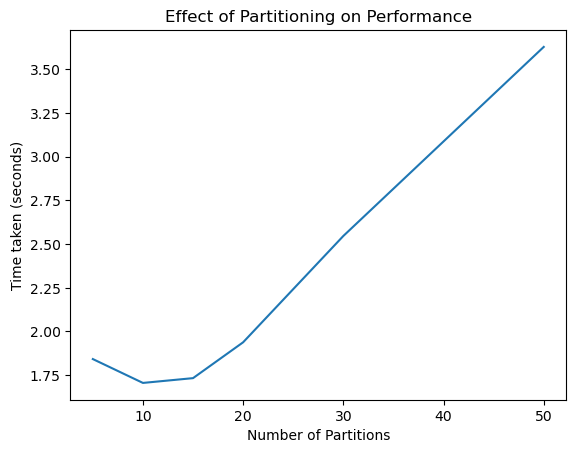

In [33]:
def task_time(shakespeare, partitions):
    shakespeare = shakespeare.repartition(partitions) # Repartition the RDD
    start_time = time.time()
    shakespeare.rdd \
    .flatMap(lambda line: line[0].split(" ")) \
    .filter(lambda word: word.lower() not in stop_words and word != "")  \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .sortBy(lambda x: x[1], ascending=False) \
    .collect()
    end_time = time.time()
    return end_time - start_time

partitions = [5, 10, 15, 20, 30, 50]

times = [task_time(shakespeare, p) for p in partitions]

optimal_partitions = partitions[times.index(min(times))] # We identify the partition size with the lowest time

print(f"The optimal number of partitions is {optimal_partitions} with a time of {min(times)} seconds\n")

# Plotting
plt.plot(partitions, times)
plt.xlabel('Number of Partitions')
plt.ylabel('Time taken (seconds)')
plt.title('Effect of Partitioning on Performance')
plt.show()

As we can observe in the graph, an initial increasing in the number of partitions improves the computation time. However, as the number of partitions increases, the repartitioning does not offer an improval in performance.

**Data Persistence**

Another way to improve our performance is by persisting our recurrently used RDD's of Dataframes. By persisting our data, we avoid the task of recomputing the data from the source everytime an action is called. There are different [persistence levels](https://spark.apache.org/docs/latest/rdd-programming-guide.html#rdd-persistence) available for set-up and the choice mostly depends on the size and type of data we are working with. To persist our data, we have two different methods:

-[*.persist()*](https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/api/pyspark.pandas.DataFrame.spark.persist.html): With this method, the user defines the storage level to persist the data.

-[*cache()*](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.cache.html): With this method, data is cached with the default level *MEMORY_AND_DISK*.

Let's make a comparison of the performance of a query in our parquet DataFrame before and after caching.

In [34]:
# Pre-caching
start_pre = time.time()
df_parquet.groupBy("Pickup Community Area") \
    .agg(F.avg("Trip Total") \
    .alias("AVG Trip Total")) \
    .na.drop(subset=["Pickup Community Area"])\
    .orderBy(F.col('Pickup Community Area')).show()
end_pre = time.time()
total_pre = end_pre - start_pre
print(f"Is the dataframe cached: {df_parquet.is_cached}")
print(f"Execution Time (Pre-cached): {total_pre}\n")

+---------------------+------------------+
|Pickup Community Area|    AVG Trip Total|
+---------------------+------------------+
|                  1.0|14.904347051776078|
|                  2.0|14.709523427124203|
|                  3.0|13.594861907566404|
|                  4.0|13.487912290478853|
|                  5.0|13.498661423394244|
|                  6.0|13.551174231054809|
|                  7.0|13.730048243649643|
|                  8.0|12.739438021830141|
|                  9.0|19.907711711711713|
|                 10.0|19.228908232118755|
|                 11.0| 15.68249312216521|
|                 12.0|20.352792553191488|
|                 13.0|14.851200775475576|
|                 14.0|15.245882238505937|
|                 15.0|14.950861089792784|
|                 16.0|14.187686900245485|
|                 17.0| 19.16936414176512|
|                 18.0| 19.99314049586777|
|                 19.0| 16.65431488275642|
|                 20.0| 18.53338563956253|
+----------

In [35]:
df_parquet.cache()
df_parquet.take(1) #We need to perform a first action to actually cache the data.

[Row(Trip ID='16c7456d99031528c238bd02f40df5ab9bdf9778', Taxi ID='88d3be8c1334607f62a8c058f680dd7fbb57826ec7408dfee0f2f25c0a0347e0afd633ec23fb657e7e97935e79974e13266f19b4a169a55190ad47fa299d2ddc', Trip Start Timestamp='01/01/2020 12:00:00 AM', Trip End Timestamp='01/01/2020 12:00:00 AM', Trip Seconds=60.0, Trip Miles=0.0, Pickup Census Tract=None, Dropoff Census Tract=None, Pickup Community Area=None, Dropoff Community Area=None, Fare=3.25, Tips=0.02, Tolls=0.0, Extras=9.0, Trip Total=12.27, Payment Type='Credit Card', Company='Top Cab Affiliation', Pickup Centroid Latitude=None, Pickup Centroid Longitude=None, Pickup Centroid Location=None, Dropoff Centroid Latitude=None, Dropoff Centroid Longitude=None, Dropoff Centroid  Location=None)]

In [36]:
# Cached
start_post = time.time()
df_parquet.groupBy("Pickup Community Area") \
    .agg(F.avg("Trip Total") \
    .alias("AVG Trip Total")) \
    .na.drop(subset=["Pickup Community Area"])\
    .orderBy(F.col('Pickup Community Area')).show()
end_post = time.time()
total_post = end_post - start_post
print(f"Is the dataframe cached: {df_parquet.is_cached}")
print(f"Execution Time (Pre-cached): {total_post}\n")

+---------------------+------------------+
|Pickup Community Area|    AVG Trip Total|
+---------------------+------------------+
|                  1.0|14.904347051776078|
|                  2.0|14.709523427124203|
|                  3.0|13.594861907566404|
|                  4.0|13.487912290478853|
|                  5.0|13.498661423394244|
|                  6.0|13.551174231054809|
|                  7.0|13.730048243649643|
|                  8.0|12.739438021830141|
|                  9.0|19.907711711711713|
|                 10.0|19.228908232118755|
|                 11.0| 15.68249312216521|
|                 12.0|20.352792553191488|
|                 13.0|14.851200775475576|
|                 14.0|15.245882238505937|
|                 15.0|14.950861089792784|
|                 16.0|14.187686900245485|
|                 17.0| 19.16936414176512|
|                 18.0| 19.99314049586777|
|                 19.0| 16.65431488275642|
|                 20.0| 18.53338563956253|
+----------

In [37]:
# Unpersisting our data
df_parquet.unpersist()

DataFrame[Trip ID: string, Taxi ID: string, Trip Start Timestamp: string, Trip End Timestamp: string, Trip Seconds: double, Trip Miles: double, Pickup Census Tract: double, Dropoff Census Tract: double, Pickup Community Area: double, Dropoff Community Area: double, Fare: double, Tips: double, Tolls: double, Extras: double, Trip Total: double, Payment Type: string, Company: string, Pickup Centroid Latitude: double, Pickup Centroid Longitude: double, Pickup Centroid Location: string, Dropoff Centroid Latitude: double, Dropoff Centroid Longitude: double, Dropoff Centroid  Location: string]

**Bucketing**

[Splitting the data into *buckets*](https://medium.com/@diehardankush/what-all-about-bucketing-and-partitioning-in-spark-bc669441db63) is another way to partition our data. In this approach, instead of partitioning the data into an n number of partitions, *buckets* can be created by partitioning the data by an specific column or set of columns. This technique is parlicularly useful when we constantly perform aggregated operations or joins. Let's take a look at an example.

In [38]:
# Non-bucketed querying
start = time.time()
df_parquet.groupBy("Pickup Community Area").agg({"Trip ID": "count", "Fare": "avg"}).show()
end = time.time()
print(f"Time: {end-start} seconds")

+---------------------+--------------+------------------+
|Pickup Community Area|count(Trip ID)|         avg(Fare)|
+---------------------+--------------+------------------+
|                  8.0|        963497|11.024886884027584|
|                 67.0|          5135|20.092132424537485|
|                 70.0|          3915| 22.66979565772669|
|                 69.0|         11130|  20.2773144654088|
|                  7.0|         78148|12.324253631070444|
|                 49.0|          9193|22.288598781549172|
|                 29.0|          5653| 19.80427636234961|
|                 75.0|          4230|23.573432624113472|
|                 64.0|           859|24.881722933643772|
|                 47.0|          1386| 23.95945887445887|
|                 42.0|         12084| 18.97675604104601|
|                 44.0|         13120| 20.43498399390244|
|                 NULL|        278916| 19.77506484798286|
|                 35.0|         24648| 15.68696964778445|
|             

In [39]:
df_parquet.write.bucketBy(10, "Pickup Community Area").sortBy("Pickup Community Area").saveAsTable("bucket_taxi")
bucketed_df = spark.table("bucket_taxi")

# Bucketed querying
start = time.time()
bucketed_df.groupBy("Pickup Community Area").agg({"Trip ID": "count", "Fare": "avg"}).show()
end = time.time()
print(f"Time: {end-start} seconds")

+---------------------+--------------+------------------+
|Pickup Community Area|count(Trip ID)|         avg(Fare)|
+---------------------+--------------+------------------+
|                 13.0|          8258|13.400220525869374|
|                 16.0|         26888|12.473036524585284|
|                 20.0|          2103|17.641583452211126|
|                 36.0|          7463|17.187135200321585|
|                 63.0|          1333|21.467599399849963|
|                 11.0|         13450|14.330103353409175|
|                 23.0|          6323|18.278257156413094|
|                 28.0|        422639|11.606287576904856|
|                 44.0|         13120| 20.43498399390244|
|                 48.0|          4795|20.324401335002083|
|                 68.0|          7109|20.732124366910522|
|                  4.0|         23330|12.656057787113644|
|                 12.0|          3760|19.468385638297875|
|                 NULL|        278916|19.775064847982197|
|             

As we stated at the beginning, finding the proper configuration tuning is a task that highly depends on the type of data you're working with, as well as your available resources. 

In this courselet we have explored some mostly to illustrate their implementation, although some of them might not have led to an actual improvement in the performance of our cluster. You're invitated to learn more about fine tuning by reading at the relevant documentation.